In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import gc

### Load data

In [2]:
%%time
unimportant_cols = []
target = 'meter_reading'
path = ''
def load_data(source = 'train', path = path):
    assert source in ['train', 'test']
    building = pd.read_csv(f'{path}building_metadata.csv')
    weather = pd.read_csv(f'{path}weather_{source}.csv', parse_dates=['timestamp'], usecols=lambda c: c not in unimportant_cols)
    df = pd.read_csv(f'{path}{source}.csv', parse_dates=['timestamp'])
    df = df.merge(building, on = 'building_id', how = 'left')
    df = df.merge(weather, on = ['site_id', 'timestamp'], how = 'left')
    return df, building, weather
train, build, weather = load_data('train')

CPU times: user 26.1 s, sys: 7.74 s, total: 33.9 s
Wall time: 34.6 s


In [37]:
test, t_build, t_weather = load_data('test')

In [91]:
build.describe()

site_id  building_id    square_feet   year_built  floor_count
count  1449.000000  1449.000000    1449.000000   675.000000   355.000000
mean      6.952381   724.000000   92111.776398  1967.957037     3.740845
std       5.003432   418.434583  110769.950997    31.054030     3.333683
min       0.000000     0.000000     283.000000  1900.000000     1.000000
25%       3.000000   362.000000   23012.000000  1949.000000     1.000000
50%       5.000000   724.000000   57673.000000  1970.000000     3.000000
75%      13.000000  1086.000000  115676.000000  1995.000000     5.000000
max      15.000000  1448.000000  875000.000000  2017.000000    26.000000

### Check target data and meter type

In [40]:
print(f'Training from {train.timestamp.min()} to {train.timestamp.max()}, \
      and predicting from {test.timestamp.min()} to {test.timestamp.max()}')

Training from 2016-01-01 00:00:00 to 2016-12-31 23:00:00,       and predicting from 2017-01-01 00:00:00 to 2018-12-31 23:00:00


count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

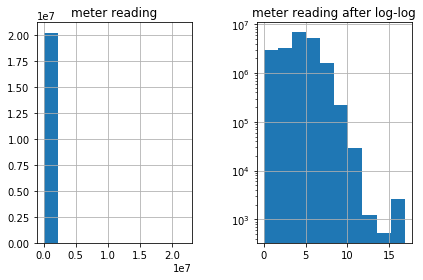

In [199]:
# target's log hist
plt.subplot(1,2,1)
ax = train[target].hist()
plt.title('meter reading')
plt.subplot(1,2,2)
ax2 = np.log1p(train[target]).hist()
plt.title('meter reading after log-log')
plt.tight_layout()

ax2.set_yscale('log')
train[target].describe()

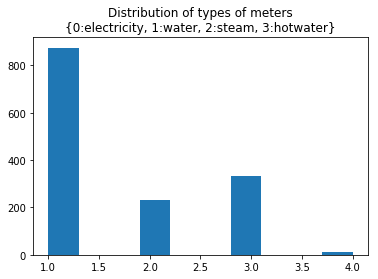

In [53]:
# check distribution in types of meters
meters = train.groupby('building_id').meter.nunique()
plt.hist(meters)
plt.title('Distribution of types of meters\n{0:electricity, 1:water, 2:steam, 3:hotwater}')
plt.show()

### Check building data

In [97]:
build.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

In [145]:
# nan percentage
build.isna().sum()/build.shape[0]

site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.534161
floor_count    0.755003
dtype: float64

In [144]:
build.primary_use.value_counts()

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

count      1449.000000
mean      92111.776398
std      110769.950997
min         283.000000
25%       23012.000000
50%       57673.000000
75%      115676.000000
max      875000.000000
Name: square_feet, dtype: float64

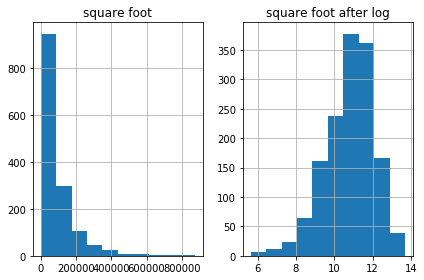

In [126]:
plt.subplot(1,2,1)
ax = build.square_feet.hist()
plt.title('square foot')
plt.subplot(1,2,2)
ax2 = np.log(build.square_feet).hist()
plt.title('square foot after log')
plt.tight_layout()
build.square_feet.describe()

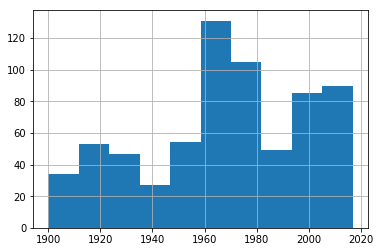

In [133]:
build.year_built.hist()
plt.show()

In [137]:
build.floor_count.value_counts()

1.0     109
2.0      67
4.0      37
3.0      33
5.0      25
6.0      25
8.0      19
7.0      14
9.0       8
11.0      5
10.0      4
12.0      2
13.0      2
19.0      1
26.0      1
14.0      1
21.0      1
16.0      1
Name: floor_count, dtype: int64

* floor_count and year_built has more than 50% nan; primary_use and square_feet don't have nan values
* square_feet is right skewed, need to do log transform

In [78]:
weather.keys()

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')

### Check time series data

In [172]:
# time series data for a single buiding
building_id = 1259 # 1258
meters = train[train['building_id'] == building_id].meter.nunique()
def plot_ts(building_id, plot_cols):
    for meter in range(meters):
        fig, ax = plt.subplots()
        plt.title(f'building {building_id} Meter {meter}')
        ax2 = ax.twinx()

        # plot meter reading
        idx = (train['building_id'] == building_id)&(train['meter'] == meter)
        dates = matplotlib.dates.date2num(train.loc[idx, 'timestamp'].astype(datetime))
        ax2.plot_date(dates, train.loc[idx, 'meter_reading'], '-', 
                      label = 'meter reading', alpha = 0.7)

        # plot air_temperature
        idx = train['building_id'] == building_id
        dates = matplotlib.dates.date2num(train.loc[idx, 'timestamp'].astype(datetime))
        ax.plot_date(dates, train.loc[idx, plot_cols], '.', color = 'tab:cyan',
                    label = plot_cols)
        ax.set_ylabel(plot_cols)
        ax2.set_ylabel('meter reading')
        ax.legend(loc = 'upper left')
        ax2.legend(loc = 'upper right')
        plt.show()
        

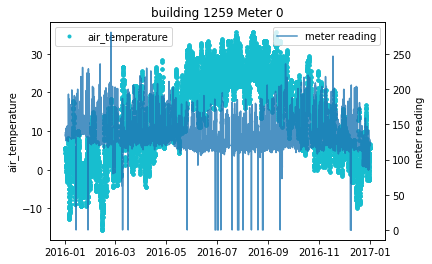

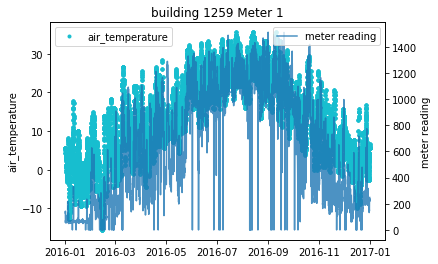

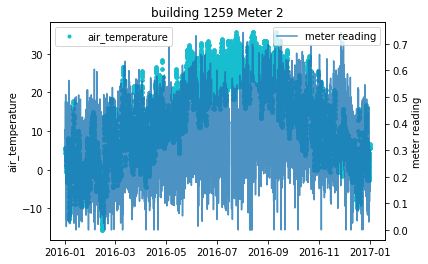

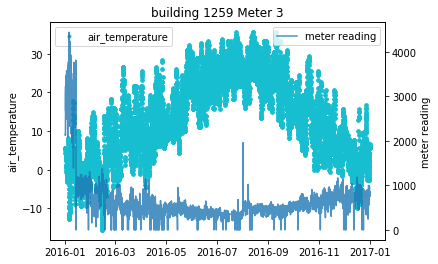

In [155]:
plot_ts(building_id, 'air_temperature')

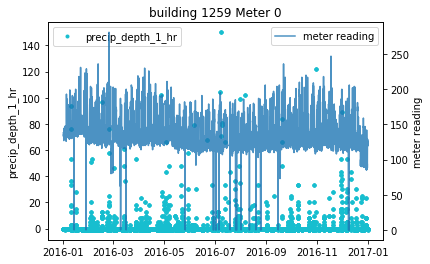

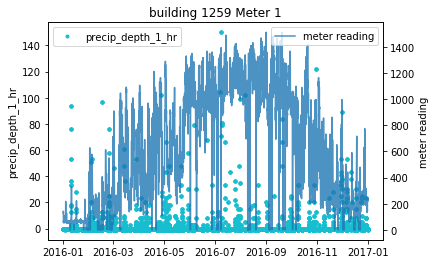

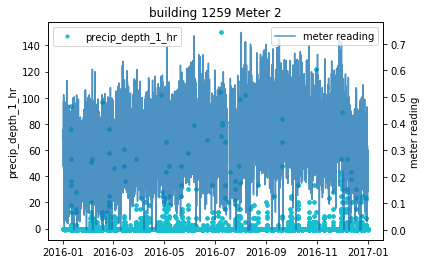

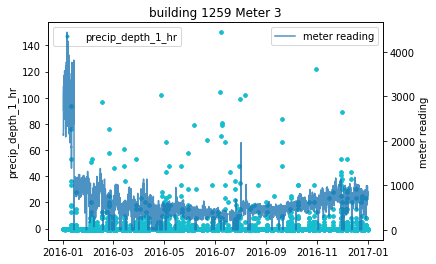

In [156]:
plot_ts(building_id, 'precip_depth_1_hr')

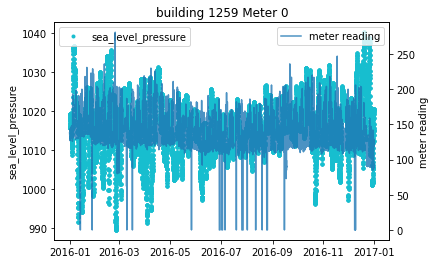

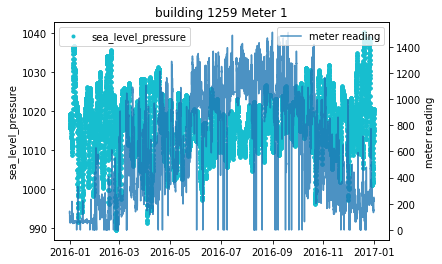

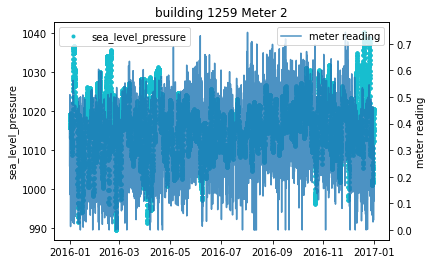

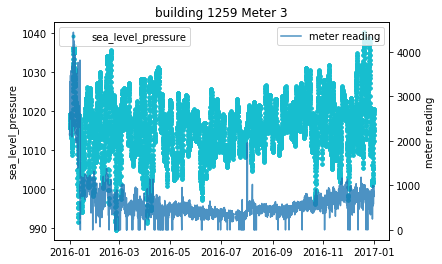

In [157]:
plot_ts(building_id, 'sea_level_pressure')

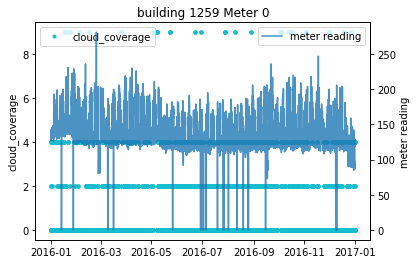

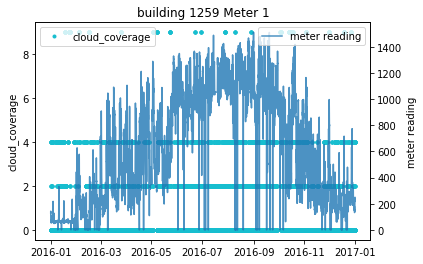

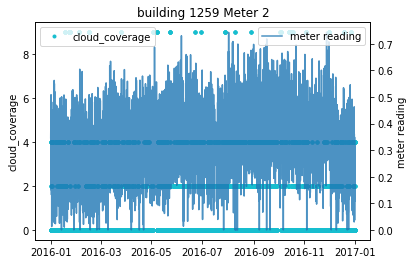

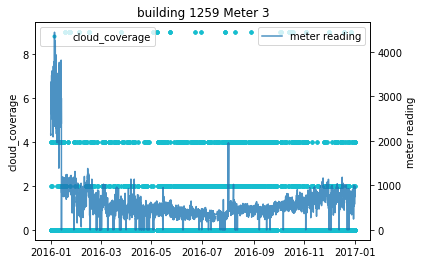

In [158]:
plot_ts(building_id, 'cloud_coverage')

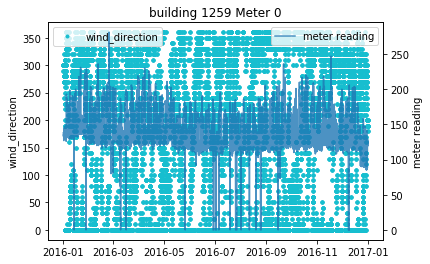

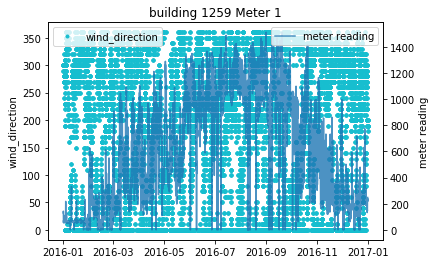

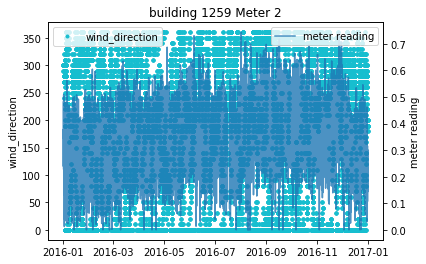

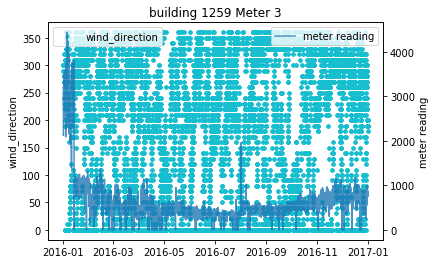

In [159]:
plot_ts(building_id, 'wind_direction')

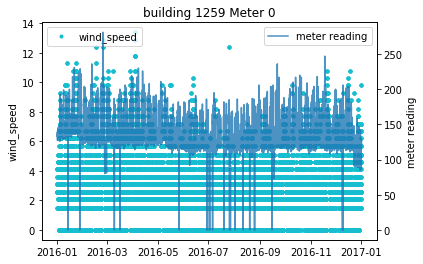

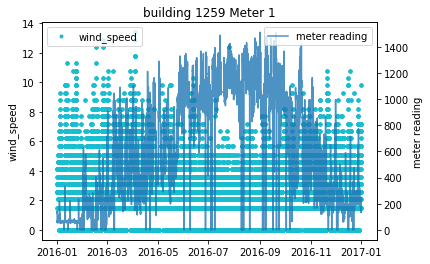

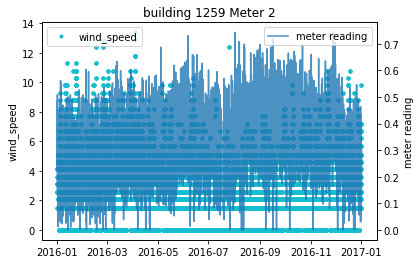

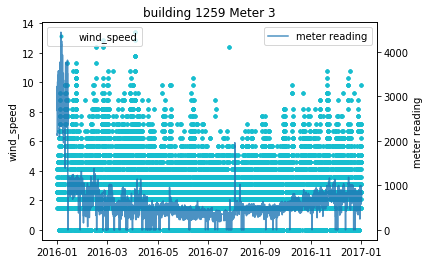

In [160]:
plot_ts(building_id, 'wind_speed')

* air_temperature and dew_temperature have similar shape, need to check colinearity. They match meter 1 very well
* sea_level_pressure seems related to meter 0 or 3
* the others, not sure

### Join train and test together, see the weather and prediction

In [181]:
building_id = 1258
def plot_train_test(building_id, meter, plot_cols):
    idx = (train['building_id'] == building_id)&(train['meter'] == meter)
    train_sample = train[idx]
    test['meter_reading'] = 0.0
    idx = (test['building_id'] == building_id)&(test['meter'] == meter)
    test_sample= test[idx]

    fig, ax = plt.subplots(figsize=(16,4))
    plt.title(f'Meter {meter} Building {building_id}')
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax2 = ax.twinx()
    
    # plot train_sample
    dates = matplotlib.dates.date2num(train_sample['timestamp'].astype(datetime))
    ax2.plot_date(dates, train_sample['meter_reading'], '-', label='train', alpha=0.8)
    ax.plot_date(dates, train_sample[plot_cols], '.', color='tab:cyan', label=plot_cols)

    # plot test_sample
    dates = matplotlib.dates.date2num(test_sample['timestamp'].astype(datetime))
    ax2.plot_date(dates, test_sample['meter_reading'], '-', label='test', alpha=0.7)
    ax.plot_date(dates, test_sample[plot_cols], '.', color='tab:cyan', label=plot_cols)

    ax.set_ylabel(plot_cols)
    ax2.set_ylabel('meter reading')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

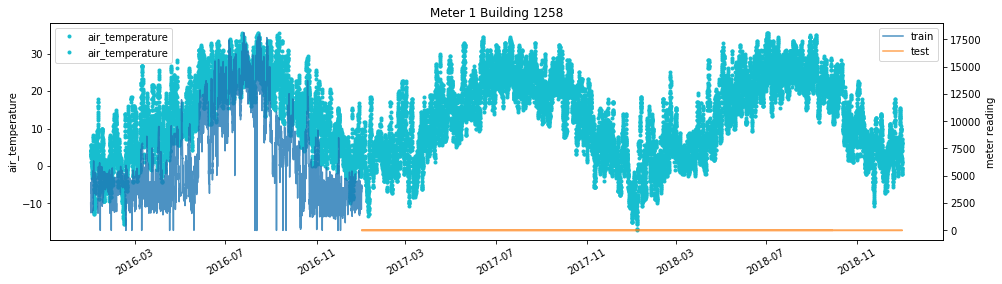

In [182]:
plot_train_test(building_id, 1, 'air_temperature')

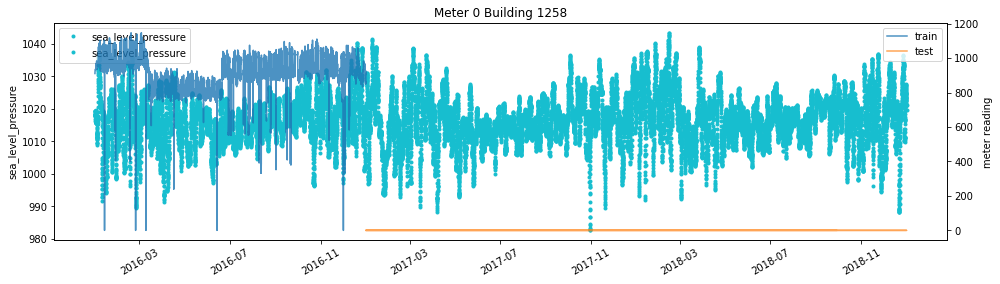

In [184]:
plot_train_test(building_id, 0, 'sea_level_pressure')

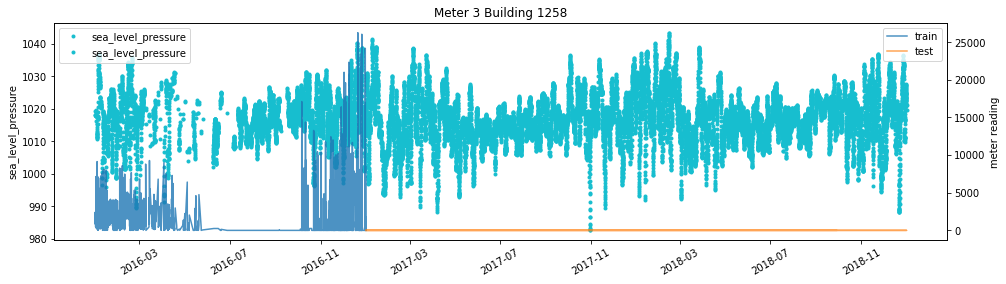

In [185]:
plot_train_test(building_id, 3, 'sea_level_pressure')

### Check missing data (drop or refill?)

In [187]:
print("Ratio of available data in train (not NAN's):")
data_ratios = train.count()/len(train)
data_ratios

Ratio of available data in train (not NAN's):


building_id           1.000000
meter                 1.000000
timestamp             1.000000
meter_reading         1.000000
site_id               1.000000
primary_use           1.000000
square_feet           1.000000
year_built            0.400100
floor_count           0.173472
air_temperature       0.995219
cloud_coverage        0.563449
dew_temperature       0.995047
precip_depth_1_hr     0.814553
sea_level_pressure    0.939075
wind_direction        0.928322
wind_speed            0.992893
dtype: float64

In [190]:
print("Ratio of available data in test (not NAN's):")
test.count()/len(test)

Ratio of available data in test (not NAN's):


row_id                1.000000
building_id           1.000000
meter                 1.000000
timestamp             1.000000
site_id               1.000000
primary_use           1.000000
square_feet           1.000000
year_built            0.410084
floor_count           0.173950
air_temperature       0.994678
cloud_coverage        0.531336
dew_temperature       0.993745
precip_depth_1_hr     0.812901
sea_level_pressure    0.939641
wind_direction        0.928565
wind_speed            0.992755
meter_reading         1.000000
dtype: float64

* both train and test miss a lot of data in year_built, floor_count and cloud_coverage
* we can fill nan with train average

In [191]:
train.loc[:, data_ratios < 1.0].mean()

year_built            1968.276736
floor_count              4.184848
air_temperature         15.987953
cloud_coverage           1.900423
dew_temperature          7.747429
precip_depth_1_hr        0.796416
sea_level_pressure    1016.085487
wind_direction         173.015104
wind_speed               3.377525
dtype: float64

### Check correlation

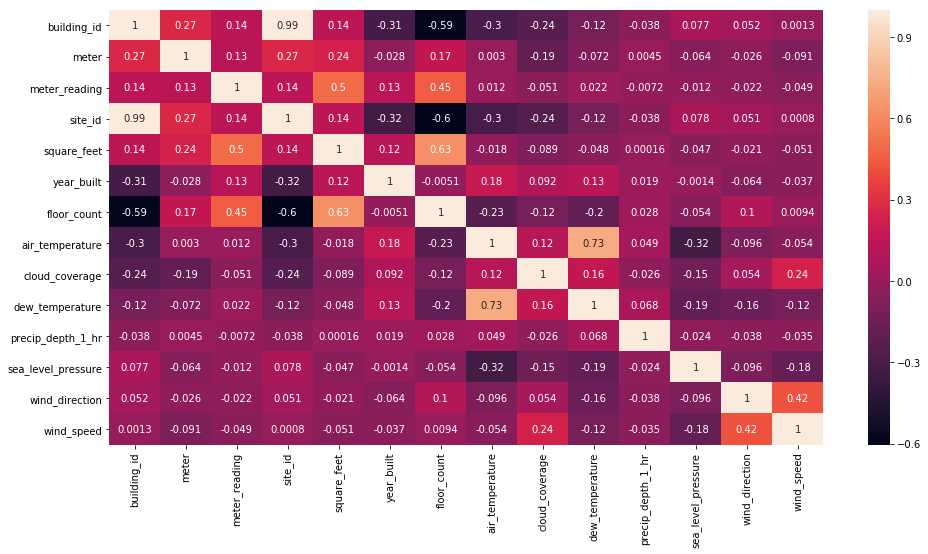

In [195]:
fig, ax = plt.subplots(figsize=(16,8))
corr = train.sample(100000).corr(method = 'spearman')
sns.heatmap(corr, annot = True, xticklabels = corr.columns.values,
           yticklabels = corr.columns.values)

* "squarefeet" and "floorcount" directly correlate with the energy, water and heating demand. So they are some of our best raw features. 
* "year_built" has also an inverse correlation with energy efficiency of a buildin
* building_id is correlated with meter reading
* air_temp and dew_temp are highly correlated
* wind_speed and wind_direction are correlated

from https://www.kaggle.com/jaseziv83/a-deep-dive-eda-into-all-variables

* meter reading is skewed. need transformation?
* meter type: We can see that the steam meter type tends to have higher meter readings, while electricity tends to have the lowest energy readings.
* not much diff btw week days but sunday has the lowest reading 
* Reading are significantly higher during traditional work hours (7-17hr) and this is to be expected.
* meter reading vs. reading hour distribution are diff when building primary_use is different 
* Utility and Healthcare places tend to have the highest readings, while Religious Worship places the least - they’re no doubt frequented less often than the higher energy users.
* the median meter reading per reading began rising in May and peaked between July and October 2016. but some primary_use type are fairly stabel over the year

### Data preprocessor

In [28]:
import numpy as np
import pandas as pd
from pathlib import Path
import os, warnings, math
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import pickle
import feather
import gc
import lightgbm as lgb
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

from os.path import join as pjoin
import cufflinks as cf
cf.go_offline(connected=False)  # to make it works without plotly account

/Users/huiminyang/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [295]:
city = ['orlando', 'heathrow', 'Phoenix', 'San Francisco', 'birmingham', 
'washington', 'ottowa', 'sanantonio', 'saltlake', 'dublin', 
'Minneapolis','Philadelphia', 'rochester']

In [301]:
fill_weather = pd.read_csv(
    'more_weather_locations.csv',
    index_col=0,
    parse_dates=True,
    infer_datetime_format=True,
).join(
    pd.read_csv(
        'temperature.csv',
        index_col=0,
        parse_dates=True,
        infer_datetime_format=True,
    ).sub(273),
    how='left',
)
fill_weather = fill_weather[city]

In [297]:
site_to_dict = {0:'orlando',
                1:'heathrow',
                2:'Phoenix',
                3:'washington',
                4:'San Francisco',
                5:'birmingham',
                6:'washington',
                7:'ottowa',
                8:'orlando',
                9:'sanantonio',
                10:'saltlake',
                11:'ottowa',
                12:'dublin',
                13:'Minneapolis',
                14:'Philadelphia',
                15:'rochester'}

In [348]:
weather_train_df = feather.read_dataframe('weather_test.feather')
weather_train_df=weather_train_df.set_index('timestamp')

In [349]:
weather_train_df.groupby('site_id')['air_temperature'].apply(lambda x: x.isna().sum())

site_id
0      0
1     22
2      0
3      2
4      0
5      0
6      4
7      0
8      0
9     54
10     8
11     0
12     0
13     2
14     2
15    10
Name: air_temperature, dtype: int64

In [353]:
weather_train_df.isna().sum()/len(weather_train_df)

timestamp             0.000000
site_id               0.000000
air_temperature       0.000004
cloud_coverage        0.506588
dew_temperature       0.001179
precip_depth_1_hr     0.344781
sea_level_pressure    0.076702
wind_direction        0.044618
wind_speed            0.001659
dtype: float64

In [338]:
timess=[]
filldict ={}
for time in weather_train_df.loc[(weather_train_df.air_temperature.isna()) & (weather_train_df.site_id == 0)].index:
    value = fill_weather.loc[fill_weather.index == time, site_to_dict[site_id]][0]
    filldict[time] = value
filldict
# weather_train_df.loc[weather_train_df.site_id == site_id, 'air_temperature'] = weather_train_df.loc[weather_train_df.site_id == site_id]['air_temperature'].fillna(filldict)
      

{Timestamp('2016-01-16 08:00:00'): 2.2,
 Timestamp('2016-01-16 09:00:00'): 2.0,
 Timestamp('2016-01-16 10:00:00'): 1.9}

In [350]:
for site_id in weather_train_df.site_id.unique():
    filldict = {}
    print(site_id)
    for time in weather_train_df.loc[(weather_train_df.air_temperature.isna()) & (weather_train_df.site_id == site_id)].index:
        value = fill_weather.loc[fill_weather.index == time, site_to_dict[site_id]][0]
        filldict[time] = value
    weather_train_df.loc[weather_train_df.site_id == site_id, 'air_temperature'] = weather_train_df.loc[weather_train_df.site_id == site_id]['air_temperature'].fillna(filldict)
        
#         w.air_temperature.fillna(value)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [351]:
weather_train_df = weather_train_df.reset_index()
weather_train_df.to_csv('filled_weather_test.csv')

In [352]:
weather_train_df

timestamp  site_id  air_temperature  cloud_coverage  \
0      2017-01-01 00:00:00        0             17.8             4.0   
1      2017-01-01 01:00:00        0             17.8             2.0   
2      2017-01-01 02:00:00        0             16.1             0.0   
3      2017-01-01 03:00:00        0             17.2             0.0   
4      2017-01-01 04:00:00        0             16.7             2.0   
...                    ...      ...              ...             ...   
277238 2018-12-31 19:00:00       15              3.3             NaN   
277239 2018-12-31 20:00:00       15              2.8             NaN   
277240 2018-12-31 21:00:00       15              2.8             NaN   
277241 2018-12-31 22:00:00       15              2.8             NaN   
277242 2018-12-31 23:00:00       15              3.3             NaN   

        dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0                  11.7                NaN              1021.4   
1                  12.8                0.0              1022.0   
2                  12.8                0.0              1021.9   
3                  13.3                0.0              1022.2   
4                  13.3                0.0              1022.3   
...                 ...                ...                 ...   
277238              1.7                NaN              1018.3   
277239              1.1                NaN              1017.8   
277240              1.7               -1.0              1017.2   
277241              2.2                8.0              1016.1   
277242              2.2               20.0              1014.7   

        wind_direction  wind_speed  
0                100.0         3.6  
1                130.0         3.1  
2                140.0         3.1  
3                140.0         3.1  
4                130.0         2.6  
...                ...         ...  
277238           150.0         7.7  
277239           140.0         5.1  
277240           140.0         6.2  
277241           140.0         5.1  
277242           140.0         5.1  

[277243 rows x 9 columns]